##### Grading Feedback Cell

# IST 718: Big Data Analytics

- Professor: Willard Williamson <wewillia@syr.edu>
- Faculty Assistant: Vidushi Mishra <vmishr01@syr.edu>
- Faculty Assistant: Pranav Kottoli Radhakrishna <pkottoli@syr.edu>
## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers from your classmates.  Short code snippets are allowed from the internet.  Code from the class text books or class provided code can be copied in its entirety.__
- There could be tests in some cells (i.e., `assert` and `np.testing.` statements). These tests (if present) are used to grade your answers. **However, the professor and FAs could use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before submitting your work, remember to check for run time errors with the following procedure:
`Kernel`$\rightarrow$`Restart and Run All`.  All runtime errors will result in a minimum penalty of half off.
- Data Bricks is the official class runtime environment so you should test your code on Data Bricks before submission.  If there is a runtime problem in the grading environment, we will try your code on Data Bricks before making a final grading decision.
- All plots shall include descriptinve title and axis labels.  Plot legends shall be included where possible.  Unless stated otherwise, plots can be made using any Python plotting package.  It is understood that spark data structures must be converted to something like numpy or pandas prior to making plots.  All required mathematical operations, filtering, selection, etc., required by a homework question shall be performed in spark prior to converting to numpy or pandas.
- Grading feedback cells are there for graders to provide feedback to students.  Don't change or remove grading feedback cells.
- Don't add or remove files from your git repo.
- Do not change file names in your repo.  This also means don't change the title of the ipython notebook.
- You are free to add additional code cells around the cells marked `your code here`.
- We reserve the right to take points off for operations that are extremely inefficient or "heavy weight".  This is a big data class and extremely inefficient operations make a big difference when scaling up to large data sets.  For example, the spark dataframe collect() method is a very heavy weight operation and should not be used unless it there is a real need for it.  An example where collect() might be needed is to get ready to make a plot after filtering a spark dataframe.
- import * is not allowed because it is considered a very bad coding practice and in some cases can result in a significant delay (which slows down the grading process) in loading imports.  For example, the statement `from sympy import *` is not allowed.  You must import the specific packages that you need.
- If you perform databricks specific operations, you MUST protect those operations in an if statement by calling the is_databricks() function provided in all homework assignments.  For example, if you use dbutils (databricks utilities), only run dbutils commands if is_databricks() returns true.  Runtime errors created in the grading environment by not protecting databricks specific commands in an if statement will result in a runtime error points deduction. 
- The graders reserve the right to deduct points for subjective things we see with your code.  For example, if we ask you to create a pandas data frame to display values from an investigation and you hard code the values, we will take points off for that.  This is only one of many different things we could find in reviewing your code.  In general, write your code like you are submitting it for a code peer review in industry.  
- Level of effort is part of our subjective grading.  Oftentimes there is a large disparity between the level of effort between students who are trying learn, and students who are trying to do the minimum possible to check off an assignment requirement.  For example, in cases where we ask for a more open ended investigation, some students put in significant effort and some students do the minimum possible to meet requirements.  In these cases, we may take points off for students who did not put in much effort as compared to students who did put in a lot of effort.  We feel that the students who did a better job deserve a better grade.  We reserve the right to invoke level of effort grading at any time.
- Only use spark, spark machine learning, spark data frames, RDD's, and map reduce to solve all problems unless instructed otherwise.
- Unless code is provided which reads data files, __you must use the get_training_filename function povided below to read data files."  Runtime errors encountered while grading caused by students not using get_training_filename will result in a minimum of half points off for the problem in question.__

In [1]:
# Do not delete or change this cell

# grading import statements
%matplotlib inline
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
sqlContext = SQLContext(sc)
import os

# Define a function to determine if we are running on data bricks
# Return true if running in the data bricks environment, false otherwise
def is_databricks():
    # get the databricks runtime version
    db_env = os.getenv("DATABRICKS_RUNTIME_VERSION")
    
    # if running on data bricks
    if db_env != None:
        return True
    else:
        return False

# Define a function to read the data file.  The full path data file name is constructed
# by checking runtime environment variables to determine if the runtime environment is 
# databricks, or a student's personal computer.  The full path file name is then
# constructed based on the runtime env.
# 
# Params
#   data_file_name: The base name of the data file to load
# 
# Returns the full path file name based on the runtime env
#
# Correct Usage Example (pass ONLY the full file name):
#   file_name_to_load = get_training_filename("sms_spam.csv") # correct - pass ONLY the full file name  
#   
# Incorrect Usage Example
#   file_name_to_load = get_training_filename("/sms_spam.csv") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("sms_spam.csv/") # incorrect - pass ONLY the full file name
#   file_name_to_load = get_training_filename("c:/users/will/data/sms_spam.csv") incorrect -pass ONLY the full file name
def get_training_filename(data_file_name):    
    # if running on data bricks
    if is_databricks():
        # build the full path file name assuming data brick env
        full_path_name = "dbfs:/FileStore/tables/%s" % data_file_name
    # else the data is assumed to be in the same dir as this notebook
    else:
        # Assume the student is running on their own computer and load the data
        # file from the same dir as this notebook
        full_path_name = data_file_name
    
    # return the full path file name to the caller
    return full_path_name

# Diamonds Data
If you have ever had an interest in diamonds then this homework is for you!  This homework assignment will use a diamonds dataset to explore spark pipelines, linear regression, feature transformation, model scoring, inference, and feature selection.

The diamonds.csv data set contains 10 columns:
- carat: Carat weight of the diamond
- cut: Describes cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal
- color: Color of the diamond, with D being the best and J the worst
- clarity: How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, etc.  See this web site for an exhaustive ranking of [clarity](https://4cs.gia.edu/en-us/diamond-clarity/?gclid=Cj0KCQjwnqH7BRDdARIsACTSAduMoc2KQbXkO94BxCfBNC5X8YyjAYcFpWThKQMW46cQj_3p0pZ0o84aAuagEALw_wcB).  The web site has a nice sliding scale you can drag to see the relationship between clarity grades.
- depth: depth % - The height of a diamond, measured from the culet to the table, divided by its average girdle diameter
- table: table% -  The width of the diamond's table expressed as a percentage of its average diameter
- price: The price of the diamond
- x: Length (mm)
- y: Width (mm)
- z: Height (mm)

# Notes:
- In this assignment __and moving forward__, we won't explicitly tell you to split data into train / test / validation sets.  It's up to you as a data scientist to know when and how to create appropriate splits for your models.  If we say to use dataframe X to train and test a model, it's up to you to know the best practicies as covered in lecture.  When you start working in industry, nobody is going to tell you when and how to split your data.  This will not be mentioned in future assignments.
- __You must use get_training_filename to generate the file name before reading the file.__  In addition, you must use get_training_filename to generate the file name before reading data files for all future assignments as well (see instructions).  We will not explicitly mention this in future homework assignments (except in the instructions).

# Question 0 (0 pts)
Please provide the following the data so we can verify your github information
- Your Name: Wanyue Xiao
- Your github user name: xwanyue0221
- Your SU email address: xwanyue@syr.edu

# Question 1 (10 pts)
Read the diamonds.csv file into a spark data frame named `diamonds_df`.

In [2]:
# Your code here
diamonds_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(get_training_filename("diamonds.csv"))
# get rid of the first column, which is the index of each row
diamonds_df = diamonds_df.drop("_c0")

In [3]:
# Grading Cell - do not modify
display(diamonds_df.toPandas().head())

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


##### Grading Feedback Cell

# Question 2 (10 pts)
Investigate the diamond data.  Create a pair plot on the real data columns which sumarizes the data. In addition to the pair plot, use a spark dataframe built in function to provide a statistical summary of the data.  Provide a written summary of the pair plot and statistical summary observations.

  summary               carat               depth               table  \
0   count               53940               53940               53940   
1    mean  0.7979397478679852   61.74940489432624   57.45718390804603   
2  stddev  0.4740112444054196  1.4326213188336525  2.2344905628213247   
3     min                 0.2                43.0                43.0   
4     25%                 0.4                61.0                56.0   
5     50%                 0.7                61.8                57.0   
6     75%                1.04                62.5                59.0   
7     max                5.01                79.0                95.0   

               price                   x                   y  \
0              53940               53940               53940   
1  3932.799721913237   5.731157211716609   5.734525954764462   
2  3989.439738146397  1.1217607467924915  1.1421346741235616   
3                326                 0.0                 0.0   
4                950  

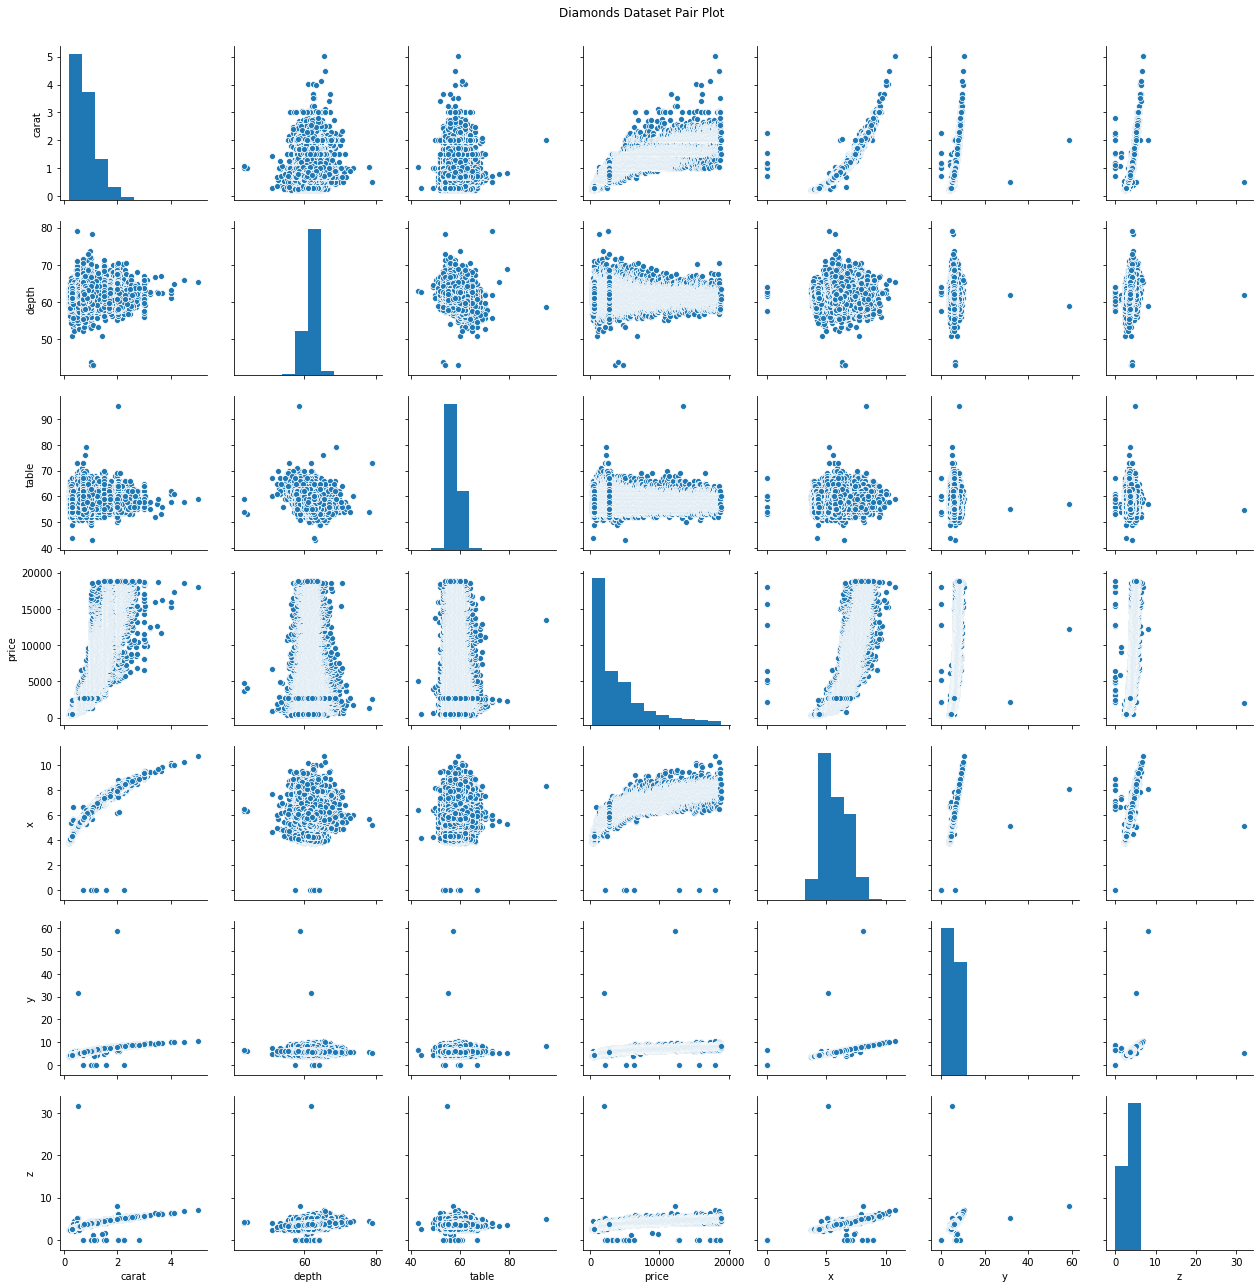

In [4]:
# Your code here
import seaborn as sns

# convert the spark dataframe to pandas dataframe in order to produce the pair plot
diamonds_pd_df = diamonds_df.toPandas()

# draw the pair plot
ax = sns.pairplot(diamonds_pd_df)
ax.fig.suptitle("Diamonds Dataset Pair Plot", y=1.02)
display()

# using pyspark build-in function to get the statistics of diamond dataset for the numeric data:
num_columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
print(diamonds_df.select(num_columns).summary().toPandas())
print("\n")

# for categorical data, print the contingency table:
cat_columns = ["cut","color","clarity"]
for i in cat_columns:
    print(i,":")
    print(diamonds_df.groupBy(i).count().show())

##### Grading Feedback Cell

Your summary explanation here:<br>
Since we dropped the first column (which is the index) of the diamonds dataset, the dataframe only has <b> 53940 rows and 10 columns </b>, including the carate, cut, color, clarity, depth, table, price, x, y, and z. Among those columns, carat, depth, table, price, x, y, and z are numeric data type while the rest three are categorical data type. Combined the pair plot and statisticas, we can divide the dataset into two groups and summarize them respectively. <br> 
For <b> numeric data</b>, the mean of depth, table, price, x, y, and z is 0.8, 61.8, 57.46, 3932.8, 5.7, 5.7, and 3.5 respectively. The median of carat (which is 0.7), depth (61.8), table (57.0), x (5.7), y (5.71), and z (3.53) is similar to its corresponding mean. The median of price, however, is significantly lower than the mean value, indicating that a potential right skewness. Similarly, the median of carat is slightly lower than the mean value, implying that the distribution of carat might be right skewed. If we compared the range of each column, it is easy to find out that a majority of column range from 0 to 10 while the two of them range from 43 to approximatly 95. The range of price is from 1000 to 9999, which is enormous. Also, if we look at the pair plot, we can see that price might have a positive relationship with carat, x, y, and z. 
<br>
For the <b> categorical data</b>, we get the frequency tables. The cut quality of the majority are Ideal, followed by Premium and Very Good. The least cut quality recorded in the dataset is Fair, which only has 1610 pbservations. The color which has the highest frequency is the "G". "E" and "F" ranked second and thrid. "H", which represents the worst color, has the fourth highest frequency. For the clarity, "SI1" and "VS2" has the first and second highest frequency respectively. It is worthwhile to point out the number of "I1" specifically, which is 741, since that value is considerably lower than the others. 
<br>
For <b>the pair plot </b>, x,y, and z have a very strong relation with price but surprisingly depth (which comes from x,y, and z) doesn't has a significant relation with price. What's more, Carat has a strong relation with price.

##### Grading Feedback Cell

# Question 3 (20 pts)
There are one or more columns of data in diamonds_df which are not in an appropriate format for performing linear regression.  Perform feature engineering on all columns which are not in a format which is ready for use in a linear regression model.  Create a new data frame named `diamonds_df_xformed` which contains the same number of columns and the same column names as diamonds_df.  Transform diamonds_df such that diamonds_df_xformed is ready to feed into a linear regression model for training.  diamonds_df_xformed Shall contain new feature engineered columns that can be directly used in linear regression.  Encapsulate your feature engineering / transformation code into a spark pipeline named feature_engineering_pipe.  Describe in words all columns on which you performed feature engineering.  Include the specific transformation algorighm used, and your reasoning for using the chosen algorithm.  We expect to see an explanation for each and every column on which you perform feature engineering.

In [5]:
# your code here
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexerModel

# get the distinct values of each categorical column
cut_list = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_list = ['J','I','H','G','F','E','D']
clarity_list = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']
# To convert the three categorical data into ordinal numeric data, we need to define the StringIndexerModel pipeline respectively
pipe_1 = Pipeline(stages=[StringIndexerModel.from_labels(cut_list, inputCol="cut", outputCol="cut_idx")])
pipe_2 = Pipeline(stages=[StringIndexerModel.from_labels(color_list, inputCol="color", outputCol="color_idx")])
pipe_3 = Pipeline(stages=[StringIndexerModel.from_labels(clarity_list, inputCol="clarity", outputCol="clarity_idx")])

# combine and encapsulate all the transformation codes into one pipeline
feature_engineering_pipe = Pipeline(stages=[pipe_1, pipe_2, pipe_3])
result = feature_engineering_pipe.fit(diamonds_df).transform(diamonds_df)

# drop the original categorical columns and change the column names
result = result.drop(*cat_columns)
diamonds_df_xformed = result.toDF(*(c.replace('_idx', '') for c in result.columns))

In [6]:
# Grading Cell do not modify
display(diamonds_df_xformed.toPandas().head())

,carat,depth,table,price,x,y,z,cut,color,clarity
0,0.23,61.5,55.0,326,3.95,3.98,2.43,4.0,5.0,1.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3.0,5.0,2.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1.0,5.0,4.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3.0,1.0,3.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1.0,0.0,1.0


##### Grading Feedback Cell

Your explanation here:<br>
There are two types of data for this dataset, which are numeric datatype and categorical datatype. Machine learning models require all input and output variables to be numeric. In order to create a dataframe which is ready for use in a linear regression model, we <b> need to convert all the categorical data to ordinal numeric data or dummy variables </b>. Those columns are "cut", "color", and "clarity". The two most popular techniques are an Ordinal Encoding and a One-Hot Encoding. Given that the question require the dataframe to contains the same number of columns and the same column names as diamonds_df, <b> we might consider StringIndexer or StringIndexerModel to conduct Ordinal Encoding </b>. 
<br>
To perform an ordinal encoding, we can use StringIndexer or StringIndexerModel. However, it seems that those categorical values inside each column have a ranking or natural ordered relationship between each other. Therefore, we <b>can only use StringIndexerModel which allows us to customize the ordered relationship via from_labels() function</b>. It is also worthwhile to indicate that <b> this might cause problems if it imposes an ordinal relationship where no such relationship may exist </b>. Take "cut" as an example. "cut" has five unique value, including 'Fair', 'Good', 'Very Good', 'Premium', and 'Ideal'. 'Ideal' has the highest quality while 'Fair' has the lowest quality. To convert this categorical data to numeric data, we can use StringIndexerModel to assign a unqiue interger value to each category. Given that we have use the from_labels() function, '4.0' has been used to represent 'Ideal' while '0.0' has been used to represent 'Fair'. Similar process has been executed for each categorical columns. For the 'color' variable, '6.0' has been used to represent 'D' (which is the best) while '0.0' has been used to represent 'J' (which is the worst). For the 'clarity' variable, '7.0' has been used to represent 'IF' (which is the best) while '0.0' has been used to represent 'I1' (which is the worst). 

##### Grading Feedback Cell

# Question 4 (10 pts)
Create a new pipeline named `diamond_pipe`.  diamond_pipe Shall contain a spark linear regression object (at a minimum) with default parameters.  Train and test diamond_pipe on the diamonds_df_xformed data frame using price as the target.  Use a spark evaluator object to score the linear regression model using mean squared error.  Print the train and test mean squared error results.

In [7]:
# your code here
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# split the dataset into train and test subsets
train, test = diamonds_df_xformed.randomSplit([0.7, 0.3], 0)
diamond_pipe = Pipeline(stages=[VectorAssembler(inputCols=diamonds_df_xformed.drop('price').columns, outputCol='features'), 
                                LinearRegression(labelCol='price', featuresCol='features')])
fitted_pipe = diamond_pipe.fit(train)

# calculate the mean squared error
# for the train dataset
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mse")
mse = fitted_pipe.stages[-1].summary.meanSquaredError
print("Mean Squared Error (MSE) on train data = %f" % mse)
# for the test dataset
mse = evaluator.evaluate(fitted_pipe.transform(test))
print("Mean Squared Error (MSE) on test data = %f" % mse)

Mean Squared Error (MSE) on train data = 1492684.985897
Mean Squared Error (MSE) on test data = 1452635.051274


##### Grading Feedback Cell

# Question 5 (10 pts)
Repeat question 4 only this time score the model using 3-fold cross validation using an empty parameter grid. Print the resulting score from 3 fold cross validation.  Briefly explain how 3 fold cross validation is different than the scoring technique used in question 4 above.

In [8]:
# your code here
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# generate the grid object, which iterates over different combinations of paramters
lrparamGrid = (ParamGridBuilder().build())

# generate a 3-fold cross validation model
lrcv = CrossValidator(estimator = diamond_pipe,
                      estimatorParamMaps = lrparamGrid,
                      evaluator = evaluator,
                      numFolds = 3)

# using the model to fit train dataset
lrcvModel = lrcv.fit(train)
print("resulting scoring of 3-fold crossvalidation = %f" % float(lrcvModel.avgMetrics[0]))

resulting scoring of 3-fold crossvalidation = 1496590.949655


##### Grading Feedback Cell

Your explanation here:<br>
Q4 split the dataset to training and testing subsets. After fitting the traning subset in the pipeline model, we can get a trained model which produced for the diamond dataset. The next step is to fit the testing subset in the trained model. Finally we can calculate the mse value. 
<br>
Unlike Q4 in which the model executed once for testing subset, CrossValidation aims to get the optimal one by generating multiple datasets AND to avoid potential over-fitting problem.<br>
CrossValidator works as splitting the dataset into a set of folds which are used as separate training and test datasets. In this case, with k equals to 3 folds, CrossValidator will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. To evaluate a particular ParamMap, CrossValidator computes the average evaluation metric for the 3 Models produced by fitting the Estimator on the 3 different (training, test) dataset pairs. In this case, the parameter grid has 0 values for CrossValidator uses 3 folds. The total number of training and evaluation cycles is 3. Then, we will use the avgMetrics to calculate the average value of those 3 models. 

##### Grading Feedback Cell

# Question 6 (10 pts)
In this question you will use inference to determine the most important predictor order.  Create a new pipeline named inference_pipe which encapsulates a standard scalar and a linear regression object (at a minimum).  After fitting the pipe, create a pandas data frame from the fitted regression model coefficients named `coefficients_df`.  coefficients_df Shall have 2 columns named `coefficient` and `value`.  The coefficient column shall contain the coefficient names and the value column shall contain the regression model coefficient absolute values.  Provide a written explanation of what the results mean.  Include a description of why we are using the standard scalar object, and how the standard scalar object allows us to perform the specified inference.

In [9]:
# your code here
import pandas as pd
from pyspark.ml.feature import StandardScaler

# create a pipline which include StandardScaler and linearRegression
inference_pipe = Pipeline(stages=[VectorAssembler(inputCols=diamonds_df_xformed.drop('price').columns, outputCol='features'),
                                  StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True),
                                  LinearRegression(labelCol='price', featuresCol='scaledFeatures')])
fitted_pipe = inference_pipe.fit(train)

# calculate the coefficient values of each feature
coeff_names = fitted_pipe.stages[0].getInputCols()
coeff_values =  [abs(ele) for ele in list(fitted_pipe.stages[-1].coefficients)]

# create a pandas dataframe to store those coefficient values
coefficients_df = pd.DataFrame(list(zip(coeff_names, coeff_values)), columns =['Coefficient', 'Value'])

In [10]:
# Grading cell do not modify
display(coefficients_df)

,Coefficient,Value
0,carat,5027.592536
1,depth,110.112723
2,table,59.566255
3,x,912.571765
4,y,43.696798
5,z,7.641985
6,cut,140.951850
7,color,551.541318
8,clarity,825.292422


##### Grading Feedback Cell

Your explanation here: <br>
The coefficient value represents the mean change in the response given a one unit change in the predictor. The sign of a regression coefficient tells you whether there is a positive or negative correlation between each independent variable the dependent variable. However, since we only record the absolute value of coefficients here, the direction of coefficient is unclear. From coefficientis printed above, we can conclude that carat have a greater impact on price comparing to other features. For example, the coefficient of carat is about 5310. Assumed the sign of this coefficient is positive, the mean response value increases by 5310 for every one unit change in the predictor, which is the price.  Note that higher x and cut also impact price but not as dramatic as carat does. Other factors also influence the price in different degree. <br>
StandardScaler transforms a dataset of Vector rows, normalizing each feature to have unit standard deviation and/or zero mean. This estimator accepts two parameters, which are withStd and withMean. The first one will scale the data to unit standard deviation while the last one will center the data with mean before scaling. The purpose of StandardScaler is to ensure all the columns or variables are equally weighted. Then, we can directly compare the absolute value of the resulting model coefficients against each other to see which coefficient is more important (makes a bigger impact) on the outcome. In this case, carat has the biggest impact.

##### Grading Feedback Cell

# Question 7 (20 pts)
Partially implement the forward stepwise selection algorithm 6.2 in ISLR. The code from this question is a partial implementation because the function specified essentially completes a single iteration of algorithm 6.2 per call. Create a function named `find_best_pred` that takes 3 arguments: A list of starting column names for the initial model, a list of column names to test for improvement, and the target column name.  Use MSE as the improvement metric.  The return value is the name of the column that provides the largest MSE improvement.  If no improvement in MSE is detected, return the string 'Null'.  Starting with the starting columns, the find_best_pred function shall return the col name that produces the largest improvement in MSE.  Check for error conditions and return the 'Null' string if there is an error in the input data.  To make it more fun, we plan on running secret tests that include errors when we grade.  Assume that you can use the diamonds_df_xformed as a global variable. You are free to decompose this problem into as many sub functions as you want as long as the main function is named find_best_pred.

In [11]:
# your code here
available_cols = diamonds_df_xformed.columns
# check if the list belongs to the available columns in diamonds_df_xformed dataset
def if_subset(ls):
    if set(ls).issubset(available_cols) is True:
        return(True)
    else:
        return(False)

def find_best_pred(int_list, test_list, target):
    # change all the elements to lowercase; remove whitespcaes and empty value
    int_list = [item.strip().lower().replace(" ", '') for item in int_list]
    int_list = ' '.join(int_list).split()
    test_list = [item.strip().lower().replace(" ", '') for item in test_list]
    test_list = ' '.join(test_list).split() 
    target = target.strip().lower().replace(" ", '')
    
    # remove potential duplictaes
    int_list = list(set(int_list))
    test_list = list(set(test_list))
    
    if len(test_list) == 0 or len(target) == 0:
        response = 'Null'
    
    # error-input checking: the int_list and test_list should not be empty; the target variable should be "price" this string
    # variable; both the int_list and test_list should belong to the available_cols.
    elif target == 'price' and len(test_list) != 0 and if_subset(test_list) and if_subset(int_list):
        
        response = []
        evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mse")
    
        if len(int_list) == 0:
            best_list = [test_list[0]]
            test_pipe = Pipeline(stages=[VectorAssembler(inputCols=best_list, outputCol='features'),
                                         LinearRegression(labelCol=target, featuresCol='features')]).fit(train).transform(test)
            int_mse = evaluator.evaluate(test_pipe)
            
            for i in test_list:
                test_pipe = Pipeline(stages=[VectorAssembler(inputCols=[i], outputCol='features'),
                                             LinearRegression(labelCol=target, featuresCol='features')]).fit(train).transform(test)
                test_mse = evaluator.evaluate(test_pipe)

                if int_mse > test_mse:
                    best_list = [i]
                    int_mse = test_mse
                elif int_mse < test_mse:
                    best_list = best_list
                else:
                    continue
        
        else:
            pipe_1 = Pipeline(stages=[VectorAssembler(inputCols=int_list, outputCol='features'),
                                      LinearRegression(labelCol=target, featuresCol='features')]).fit(train).transform(test)
            int_mse = evaluator.evaluate(pipe_1)
            best_list = int_list
            
            for i in test_list:
                test_pipe = Pipeline(stages=[VectorAssembler(inputCols=int_list+[i], outputCol='features'),
                                             LinearRegression(labelCol=target, featuresCol='features')]).fit(train).transform(test)
                test_mse = evaluator.evaluate(test_pipe)

                if int_mse > test_mse:
                    best_list = int_list+[i]
                    int_mse = test_mse
                else:
                    continue
            
        if best_list != int_list:
            response = [item for item in best_list if item not in int_list]
        elif best_list == int_list:
            response = 'Null'
   
    else:
        response = 'Null'
    return(response)

In [12]:
# Grading cell - do not modify
print(find_best_pred([], ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))
print(find_best_pred(['carat', 'cut'], ['color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat']
['clarity']


##### Grading Feedback Cell

# Question 8 (10 pts)
Finish implementing the forward stepwise selection algorithm 6.2 in ISLR.  Question 7 implemented a single iteration of ISLR algorithm 6.2.  The purpose of this question is to create a driver function that will iteratively call the find_best_pred function defined in question 7 to create the complete ordered list of best predictors.  Create a new function named `get_stepwise_pred_list` which iteratively calls find_best_pred to build an ordered list of the best stepwise features. Terminate building the list if find_best_pred returns Null or you run out of predictors to test - whichever comes first.  get_stepwise_pred_list Takes 2 arguments:  A list of all predictors and the dataset target column.   get_stepwise_pred_list Returns a list containing the ordered stepwise features selected by iteratively calling find_best_pred.  

In [13]:
# your code here
def get_stepwise_pred_list(remaining, target):
    # change the all the elements to lowercase and remove whitespaces
    remaining = [item.strip().lower().replace(" ", '') for item in remaining]
    target = target.strip().lower().replace(" ", '')
    # remove empty value inside the list
    remaining = ' '.join(remaining).split() 
    # remove potential duplictaes
    remaining = list(set(remaining))
    
    if len(target) == 0 or len(remaining) == 0:
        raise IOError('List or target should not be empty')
    elif target == 'price' and len(remaining) != 0 and if_subset(remaining):
        best = []
        iteration = len(remaining)
        
        # now we need to get a ordered list of the columns 
        while iteration > 0:
            result = find_best_pred(best, remaining, target)
            
            if result != 'Null':
                best.append(result[0])
                remaining.remove(result[0])
                iteration = len(remaining)
            elif result == 'Null':
                break

    else:
        raise IOError('Error Input in List')
    
    return(best)

In [14]:
# grading cell do not modify
print(get_stepwise_pred_list(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'price'))

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'z']


##### Grading Feedback Cell

# Extra Credit (10 pts)
Question 7 creates a function that is specific to the diamonds data set.  The problem with the scheme is that it only works for one data set and it assumes a very specific model.  Being a great data scientist, you realize that the code would be significantly more valuable if it was more flexible.  The right thing to do is extend the functionality of the code to be able to use any pipeline and any data set.  Start by adding a data frame argument to get_stepwise_pred_list.  get_stepwise_pred_list Will then need to pass the data frame to the find_best_pred function.  This solves the problem of being able to operate with any data frame.

There is a bigger problem.  We need a way to build a custom model built specifically for the data frame. Currently, we are building a very specific custom model in the find_best_pred function that is customized for only one data frame - the diamond data frame.  We need to come up with a way to customize the pipeline for any data frame. One solution to this problem is to create a user defined callback function which builds the pipelines. The callback function will take as input arguments a list of feature names to train on, and return a ready to use spark pipeline.  Add the callback function to the get_stepwise_pred_list argument list.  Port the code that builds the pipe which was previously defined in the find_best_pred function to your new user defined callback function.  Now instead of building the pipe in find_best_pred, the find_best_pred function will call the callback function to build the pipe.  With this piece of the puzzle solved, we are a lot closer to having the level of flexibility you would need for a production environment.  Notwithstanding, there are still other problems to solve.  For example, we also need to be able to specify the loss function to use - MSE is not the best loss function for say a logistic regression pipe.  It would also be great if we could encapsulate all of this functionality into a python class.  But to get full credit for this problem, you only need the pipe function callback and to add the dataframe as an argument.  

Your are free to add arguments or change things some from the above description. The above is only a loose guide.  Experiment and have fun. 

Demonstrate your results by executing the updated code using the test from problem 8 above.

In [18]:
# your code here
def callback(cb_list, target):
    # try to customize a linear regression pipeline
    callback_pipe = Pipeline(stages=[VectorAssembler(inputCols=cb_list, outputCol='features'),
                                     LinearRegression(labelCol=target, featuresCol='features')])
    return(callback_pipe)

def find_best_pred(train, test, function, int_list, test_list, criterion, target):
    # clean the inputs: remove duplicates, whitespaces, and null values
    int_list = [item.strip().lower().replace(" ", '') for item in int_list]
    int_list = ' '.join(int_list).split()
    test_list = [item.strip().lower().replace(" ", '') for item in test_list]
    test_list = ' '.join(test_list).split() 
    target = target.strip().lower().replace(" ", '')
    int_list = list(set(int_list))
    test_list = list(set(test_list))
    
    if len(test_list) == 0 or len(target) == 0:
        response = 'Null'
    
    # error-input checking: the int_list and test_list should not be empty; the target variable should be "price" this string
    # variable; both the int_list and test_list should belong to the available_cols.
    elif target == 'price' and len(test_list) != 0 and if_subset(test_list):
        
        response = []
        evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName=criterion)
    
        if len(int_list) == 0:
            best_list = [test_list[0]]
            test_pipe = function(best_list, target).fit(train).transform(test)
            int_mse = evaluator.evaluate(test_pipe)
            
            for i in test_list:
                test_pipe = function([i], target).fit(train).transform(test)
                test_mse = evaluator.evaluate(test_pipe)

                if int_mse > test_mse:
                    best_list = [i]
                    int_mse = test_mse
                elif int_mse < test_mse:
                    best_list = best_list
                else:
                    continue
        
        else:
            int_pipe = function(int_list, target).fit(train).transform(test)
            int_mse = evaluator.evaluate(int_pipe)
            best_list = int_list
            
            for i in test_list:
                test_pipe = function(int_list+[i], target).fit(train).transform(test)
                test_mse = evaluator.evaluate(test_pipe)

                if int_mse > test_mse:
                    best_list = int_list+[i]
                    int_mse = test_mse
                else:
                    continue
            
        if best_list != int_list:
            response = [item for item in best_list if item not in int_list]
        elif best_list == int_list:
            response = 'Null'  
   
    else:
        response = 'Null'
        
    return(response)

def get_stepwise_pred_list(df, function, remaining, criterion, target):
    '''
    forward stepwise regression
    
    argument:
    df: the clean and organized dataframe in which the data types of columns have been validated 
        or converted to numeric type.
    function: the function that is used to develop the pipeline
    remaining: the name list of columns that user wish to train on
    target: the target variable of linear regression
    criterion: the loss function, available choices are 'rmse', 'mse', 'mae', and 'var'
    '''
    
    criterion_list = ['rmse', 'mse', 'mae', 'var']
    if criterion not in criterion_list:
        raise IOError('Error criterion Input, Please Select One：', '\n', criterion_list)
    
    available = df.columns
    remaining = [item.strip().lower().replace(" ", '') for item in remaining]
    target = target.strip().lower().replace(" ", '')
    remaining = ' '.join(remaining).split() 
    remaining = list(set(remaining))
    
    if set(remaining).issubset(df.columns) is False:
        raise IOError('Wrong Input List')
    
    # splite the dataframe to train and test dataset
    train, test = df.randomSplit([0.7, 0.3], 0)
    
    if len(target) == 0 or len(remaining) == 0:
        best = "List or target should not be empty"
    elif target == 'price' and len(remaining) != 0 and set(remaining).issubset(df.columns):
        best = []
        iteration = len(remaining)
        
        # now we need to get a ordered list of the columns 
        while iteration > 0:
            result = find_best_pred(train, test, function, best, remaining, criterion, target)
            
            if result != 'Null':
                best.append(result[0])
                remaining.remove(result[0])
                iteration = len(remaining)
            elif result == 'Null':
                break
 
    else:
        best = 'Error Input in List'
    return(best)

In [19]:
# define a list of feature names to train on
get_stepwise_pred_list(diamonds_df_xformed, callback, ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z'], 'rmse', 'price') 

['carat', 'clarity', 'color', 'x', 'cut', 'depth', 'table', 'y', 'z']

##### Grading Feedback Cell